## Inversion von Geoelektrik-Daten


In [1]:
import numpy as np
import scipy.special as scp
import matplotlib.pyplot as plt
import time

def precompute_bessel_function(L_model,dx,n_max):
    vec = np.arange(0,n_max+dx,dx); 
    bessel = np.zeros([len(L_model),len(vec)])
    for jdx,L in enumerate(L_model):
        for idx,lamb in enumerate(vec):
            bessel[jdx,idx] = scp.jv(1,lamb*L)*lamb
    return bessel

def forward_model_1(rho,d,L_model,bessel,dx,n_max): 
    ''' Berechnet die scheinbaren spezifischen Widerstände für Schichten mit der
        Dicke d und spezifischen Widerständen rho für bestimmte Auslagenlängen L/2 

    © Nepomuk Boitz, Mai 2019, boitz@geophysik.fu-berlin.de
'''
    ## Initialize parameters
    n = len(rho); 
    K = np.zeros([n]); 
    T = np.zeros([n])
    vec1 = np.arange(0,n_max+dx,dx); 
    T_star = np.zeros(len(vec1))
    P = np.zeros([n-1])
    rho_a = np.zeros([len(L_model)])
    temp = np.zeros([n-1,len(vec1)])
    check = np.zeros([n-1,len(vec1)])
    K[n-1] = 1; 
    # Precomputations
    for i in range(0,n-1):
        P[i] = rho[i]/rho[i+1]; 
        for idx,lamb in enumerate(vec1):
            temp[i,idx] = np.tanh(d[i]*lamb)

    vec = np.arange(n-2,-1,-1)
    count = 0; 
    for idx,lamb in enumerate(vec1):  
        for i in vec:
            K[i] = (K[i+1]+P[i]*temp[i,idx])/(P[i] + K[i+1]*temp[i,idx]);
            check[i,idx] = K[i]
        T_star[idx] = rho[0]*check[0,idx];
    
    
    # Forward Modeling     
    for jdx,L in enumerate(L_model):
        fac = 0;
        for idx,lamb in enumerate(vec1):
            fac = fac + (((T_star[idx]-rho[0])*bessel[jdx,idx])*dx);
        fac = rho[0]+L**2*fac; 
        rho_a[count] = fac;   
        count += 1; 

    return rho_a

def invert_model(n_realisation,it_max,start_model,data,dx,n_max):
    history = np.zeros([n_realisation,len(start_model)+1])
    bessel = precompute_bessel_function(data[:,0],dx,n_max)
    n_layer = len(start_model)//2+1
    for j in range(n_realisation):
        rho = start_model[range(0,len(start_model)//2+1)]; 
        d = start_model[range(len(start_model)//2+1,len(start_model))]; 
        rho_a = forward_model_1(rho,d,data[:,0],bessel,dx,n_max);
        misfit = np.linalg.norm(np.log10(rho_a)  - np.log10(data[:,2]),2); 
        mis = np.zeros(it_max)
        a = time.time()
        for i in range(it_max):
            rho_update = np.random.randn(n_layer)*fac*rho;
            d_update =np.random.randn(n_layer-1)*fac*d;
            rho_a = forward_model_1(rho+rho_update,d+d_update,data[:,0],bessel,dx,n_max);
            mis[i] = np.linalg.norm(np.log10(rho_a)  - np.log10(data[:,2]),2);
            if (mis[i] < misfit):
                misfit = mis[i];
                rho  = rho+rho_update;
                d = d+d_update;
        history[j,:] = np.concatenate([rho, d,np.array( [mis[i]])]);
        b = time.time()
        print(b-a)
    return history
def plot_single_model(data,rho_a): 
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.loglog(data[:,0],data[:,2],'b.-')
    ax.loglog(data[:,0],rho_a,'r.-')
    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlabel('L/2 [m]')
    plt.ylabel('scheinbarer spezifischer Widerstand [Ohm m]')
    plt.legend(['Data','Modell-Fit'])
    plt.title('Datenanpassung durch das beste invertierte Modell')
    
def plot_equivalent_models(history):
    fig, ax = plt.subplots(figsize=(8, 8))

    n_layer = np.size(history,1)//2
    for i in range(np.size(history,0)):
        z = np.zeros(2*n_layer)
        rho = np.zeros(2*n_layer)
        for j in range(n_layer):
            rho[range(j*2,j*2+2)] = history[i,j]
        for j in range(n_layer-1):
            z[range(j*2+1,j*2+3)] = history[i,n_layer+j] + z[j]
        z[n_layer*2-1] = 20
        plt.loglog(rho,z,'k--')
        if np.argmin(history[:,np.size(history,1)-1])==i:
            plt.loglog(rho,z,'r-')
        #plt.yscale('log')
    plt.gca().invert_yaxis()
    plt.ylabel('Tiefe [m]')
    plt.xlabel('Spezifischer Widerstand [Ohm m]')
    
    
    

In [2]:
# Messdaten [L/2,Geometruefaktor,scheinbarer spezifischer Widerstand]
data = np.array([[1.33,79.9890,381.69],
                 [1.78,30.0490,275.50],
                 [2.37,9.9592,167.92],
                 [3.16,2.7613,84.46],
                 [4.22,1.0549,58.19],
                 [5.62,0.5077,49.98],
                 [7.50,0.3067,53.96],
                 [10.00,0.1815,56.88],
                 [13.34,0.1102,61.52],
                 [17.78,0.0557,55.27],
                 [23.71,0.0303,53.49],
                 [31.62,0.0157,49.30],
                 [42.17,0.0080,44.69]]) 

# Startmodell
rho_start = np.array([500,20,100,10]); 
d_start = np.array([1,1,8]); 
start_model = np.concatenate([rho_start,d_start])

# Inversionparameter
dx = .075 # Paramter für das numerische lösen des Intergrals (am besten so lassen)
n_max = 30; # Paramter für das numerische lösen des Intergrals (am besten so lassen)
fac = .15; # kontrolliert wie groß ein einzelnes Modellupdate sein soll
it_max = 400; #% Anzahl der Modelle pro Iteration die getestet werden
n_realisation = 5; # Wie viele Equivalenzmodelle sollen berechnet werden ? 

# Inversion wird gestartet#
bessel = precompute_bessel_function(data[:,0],dx,n_max)
history = invert_model(n_realisation,it_max,start_model,data,dx,n_max)


11.918173789978027
10.577857971191406
10.352753639221191
10.408938884735107
10.421563148498535


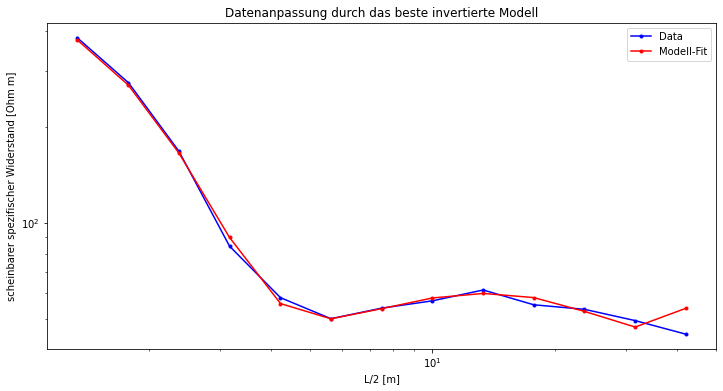

In [3]:
# Find best model 
which_model = np.argmin(history[:,np.size(history,1)-1])

# Plot best model
rho_final = history[which_model,range(0,np.size(history,1)//2)]; 
d_final = history[which_model,range(np.size(history,1)//2,np.size(history,1)-1)]; 
rho_a = forward_model_1(rho_final,d_final,data[:,0],bessel,dx,n_max)
plot_single_model(data,rho_a)

In [ ]:
# Plot Equivalent-Models
plot_equivalent_models(history)